# Virtual Acoustic Environments Spring 2022
## Project 9: Headphone Equalization
**Author: Alpar Gür**

**Supervisor: David Bau**

**Professor: Christoph Pörschmann**

---
This notebook is to extract and write the impulse responses recorded from Beats Detox headphone. Reason being is that the sweep recordings of Beats Detox are sample rate of 48000 Hz.

In [1]:
# load packages
import numpy as np
import sounddevice as sd
import soundfile as sf
import pyfar as pf
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from time import sleep
from collections import defaultdict
from numpy import ndarray, ceil, log2, append

In [2]:
def convert_audio_to_numpy_array(recording_path: str):
    data, samplerate = sf.read(recording_path, dtype='float32')
    return data, samplerate
    
def record_sound(duration: int, samplerate: int, channel_count: int):
    return sd.rec(int(duration * samplerate), samplerate=samplerate, channels=channel_count)

def play_sound(recording: ndarray, samplerate: int):
    sd.play(recording, samplerate)

def play_and_record(recording, samplerate, channels):
    return sd.playrec(recording, samplerate, channels, dtype='float64')

In [3]:
# define global parameters
fs = 44100
nyquist = fs / 2.0
recording_count = 10
headphones = ['Beats_Detox']

In [4]:
# import played sweep_sound
sweep, sweep_fs = convert_audio_to_numpy_array(f"../sounds/input/sweep_fs_44100_mono.wav")
print('Audio:\t\t Sweep')
print(f'Sample Rate:\t {sweep_fs}')
print(f"Shape:\t\t {sweep.shape}")

Audio:		 Sweep
Sample Rate:	 44100
Shape:		 (88642,)


In [5]:
sd.play(sweep, sweep_fs)

In [6]:
headphone_sweep_sounds = defaultdict(dict)

for headphone in headphones:
    print(f'Headphone:\t {headphone}')
    for i in range(recording_count):
        sweep, fs = convert_audio_to_numpy_array(f"../sounds/sweeps/{headphone}/pass0{i}.wav")
        headphone_sweep_sounds[headphone][i] = sweep
    headphone_sweep_sounds[headphone]['fs'] = fs
    print(f'Sample Rate:\t {fs}')
    print(f'Shape:\t\t {sweep.shape}')

Headphone:	 Beats_Detox
Sample Rate:	 44100
Shape:		 (88818, 2)


In [7]:
# play sweep
sd.play(headphone_sweep_sounds['Beats_Detox'][0], fs)

Visualize Sweep

/Users/alpargur/Library/Mobile Documents/com~apple~CloudDocs/Uni/Semester-2/VAE/Project/vae-22-project/venv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


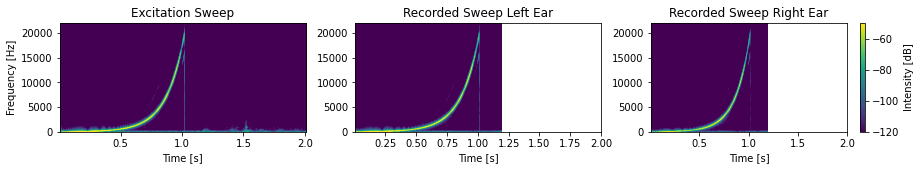

In [8]:
s = sweep[:, 0]
y_l = headphone_sweep_sounds['Beats_Detox'][0][:, 0]
y_r = headphone_sweep_sounds['Beats_Detox'][0][:, 1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 2))

ax1.set_title('Excitation Sweep')
ax1.set_ylabel("Frequency [Hz]")
ax1.set_xlabel("Time [s]")
ax2.set_title('Recorded Sweep Left Ear')
ax2.set_xlabel("Time [s]")
ax3.set_title('Recorded Sweep Right Ear')
ax3.set_xlabel("Time [s]")

v_min = -120
v_max = -50

_, _, _, cax1 = ax1.specgram(s, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max)
_, _, _, cax2 = ax2.specgram(y_l, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max)
_, _, _, cax3 = ax3.specgram(y_r, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max)

fig.colorbar(cax3, ax=ax3).set_label('Intensity [dB]')

### Deconvolution

In [9]:
def pad_array(recording: ndarray):
    # define length of FFT (zero padding): at least double length of input
    input_length = recording.size
    n = ceil(log2(input_length)) + 1
    N_fft = int(pow(2, n))
    N_single_sided = N_fft/2+1

    print(f'Input Length:\t {input_length}')
    print(f'n:\t\t {n}')
    print(f'N_fft:\t\t {N_fft}')
    print(f'N_single_sided:\t {N_single_sided}')

    return input_length, N_fft, N_single_sided

In [10]:
def transform_time_to_frequency_domain(audio: ndarray, recording: ndarray, N_fft: int):
    y_l = recording[:, 0] # left channel
    y_r = recording[:, 1] # right channel
    
    X_f = rfft(audio, N_fft)
    Yl_f = rfft(y_l, N_fft)
    Yr_f = rfft(y_r, N_fft)

    return y_l, y_r, X_f, Yl_f, Yr_f



In [11]:
def compute_filter(X_f, Yl_f, Yr_f):
    X_f_inv = 1 / X_f
    Hl_f = Yl_f * X_f_inv
    Hr_f = Yr_f * X_f_inv

    return Hl_f, Hr_f
    

In [12]:
def transform_frequency_to_time_domain(Hl_f, Hr_f, N_fft, input_length):
    # backward transform
    hl = irfft(Hl_f, N_fft)
    hr = irfft(Hr_f, N_fft)
    # truncate to original length
    hl = hl[:int(input_length/2)]
    hr = hr[:int(input_length/2)]

    return hl, hr

In [13]:
def make_sweep_stereo(y_l, y_r):
    sweep_stereo = append([y_l], [y_r], axis=0)
    sweep_stereo = sweep_stereo.transpose() 
    return sweep_stereo

In [14]:
def create_impulse_response(hl, hr):
    impulse_response = append([hl], [hr], axis=0)
    impulse_response = impulse_response.transpose()
    return impulse_response

In [15]:
def deconvolve(audio, recording):
    input_length, N_fft, N_single_sided = pad_array(recording)
    y_l, y_r, X_f, Yl_f, Yr_f = transform_time_to_frequency_domain(audio, recording, N_fft)
    Hl_f, Hr_f = compute_filter(X_f, Yl_f, Yr_f)
    hl, hr = transform_frequency_to_time_domain(Hl_f, Hr_f, N_fft, input_length)
    sweep_stereo = make_sweep_stereo(y_l, y_r)
    impulse_response = create_impulse_response(hl, hr)

    return sweep_stereo, impulse_response

In [16]:
def write_sweep(recording, fs, headphone, epoch):
    write(f"../sounds/sweeps/{headphone}/{headphone}_sweep_{epoch}.wav", fs, recording)

def write_impulse_response(recording, fs, headphone, count):
    write(f"../sounds/impulse_responses/{headphone}/pass0{count}.wav", fs, recording)

In [17]:
headphone_sweep_deconvolved = defaultdict(dict)
headphone_impulse_responses = defaultdict(dict)

for headphone in headphones:
    print(f'Headphone:\t {headphone}')
    for i in range(recording_count):
        sweep_stereo, impulse_response  = deconvolve(sweep, headphone_sweep_sounds[headphone][i])
        headphone_sweep_deconvolved[headphone][i] = sweep_stereo
        headphone_impulse_responses[headphone][i] = impulse_response
    print(f'Sweep Shape:\t {sweep_stereo.shape}')
    print(f'IR Shape:\t {impulse_response.shape}')



Headphone:	 Beats_Detox
Input Length:	 177284
n:		 19.0
N_fft:		 524288
N_single_sided:	 262145.0


### Write IRs as wav file

In [ ]:
for headphone in headphones:
    for count in range(recording_count):
        write_impulse_response(headphone_impulse_responses[headphone][i], fs, headphone, count)